In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from transforms import Affine, PReLU, Planar, Radial
from flows import Flow
tfd = tfp.distributions

In [2]:
k = 2
n_layers = 4
affine = Affine(input_dims=k)
prelu = PReLU()
planar = Planar(k)
radial = Radial(k)
transform = planar
for i in range(n_layers - 1):
    transform = planar(radial(transform))

In [3]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros((k,)))

In [4]:
flow = Flow(base_dist, transform, learning_rate=1.0E-4, name='affine_gaussian')

In [5]:
x1_samples = tfd.Normal(loc=2.0, scale=0.5).sample(1024)
x2_samples = tfd.Normal(loc=2.0*x1_samples**2.0, scale=0.1*tf.ones(x1_samples.shape)).sample()
x_samples = tf.stack([x2_samples, x1_samples], axis=1)

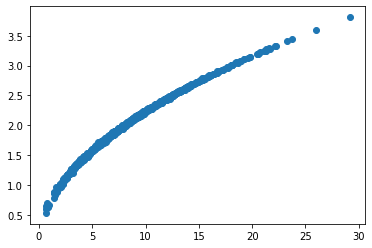

In [6]:
plt.scatter(x_samples[:,0], x_samples[:,1])

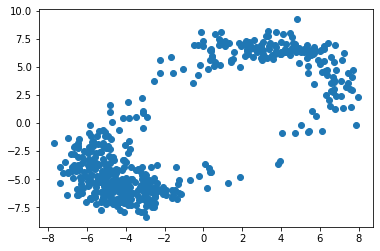

In [7]:
flow_dist_samples = flow.dist.sample(512)
plt.scatter(flow_dist_samples[:,0], flow_dist_samples[:,1])

In [8]:
print(x_samples[:1])
y = radial.forward(x_samples[:1])
print(y)
print(radial.inverse(y))
y = planar.forward(x_samples[:1])
print(y)
print(planar.inverse(y))

tf.Tensor([[5.795679  1.7152822]], shape=(1, 2), dtype=float32)
tf.Tensor([[6.76754   1.9423373]], shape=(1, 2), dtype=float32)
tf.Tensor([[5.795679  1.7152822]], shape=(1, 2), dtype=float32)
tf.Tensor([[6.4857373 2.4053407]], shape=(1, 2), dtype=float32)
tf.Tensor([[5.795679  1.7152822]], shape=(1, 2), dtype=float32)


In [9]:
print(radial.inverse_log_det_jacobian(radial.forward(x_samples[:1]), event_ndims=1))

tf.Tensor([[-7.7825046]], shape=(1, 1), dtype=float32)


W0801 00:04:31.956944 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359ebffe08> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0801 00:04:31.961107 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359ea36ae8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

W0801 00:04:32.009742 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359c169f48> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0801 00:04:32.014227 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359c169ea8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

W0801 00:04:32.065141 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359c105ae8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0801 00:04:32.068469 139871652026176 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x7f359c105bd8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env vari

(iteration 0) log loss: 20.115385055541992


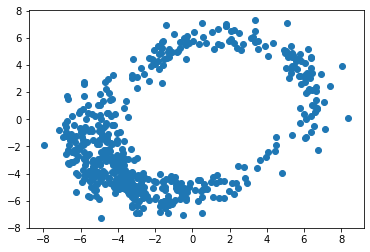

InvalidArgumentError: nan/inf gradient for b_2:0 : Tensor had NaN values
	 [[{{node VerifyFinite_12/CheckNumerics}}]] [Op:__inference_train_on_batch_16650]

In [10]:
for i in range(10000):
    log_loss, grads = flow.train_on_batch(x_samples)
    if i % 100 == 0:
        #vars_grads = list(zip(map(flow.trainable_variables), map(lambda g: g.numpy(), grads)))
        print(f'(iteration {i}) log loss: {log_loss.numpy()}')
    if i % 1000 == 0:
        samples = flow.dist.sample(512)
        plt.scatter(samples[:,0], samples[:,1])
        plt.show()